# Deep Learning Based Emotion Recognition with PyTorch

![alt txt](img/emotion_classifier.png)

In this notebook we are going to learn how to train deep neural networks, such as recurrent neural networks (RNNs), for addressing a natural language task known as **emotion recognition**. We will cover everything you need to know to get started with NLP using deep learning frameworks such as TensorFlow. We will cover the common best practices, functionalities, and steps you need to understand the basics of PyTorch APIs to build powerful predictive models via the computation graph. In the process of building our models, we will compare PyTorch and TensorFlow to let the learner appreciate the strenghts of each tool.

by [Elvis Saravia](https://twitter.com/omarsar0)

---

## Outline
1. Deep Learning Frameworks
     - 1.1 Eager execution
     - 1.2 Computation graph
2. Tensors
    - 2.1 Basic math with tensors
    - 2.2 Transforming tensors
3. Data
    - 3.1 Preprocessing data
        - Tokenization and Sampling
        - Constructing Vocabulary and Index-Word Mapping
    - 3.2 Converting data into tensors
    - 3.3 Padding data
    - 3.4 Binarization
    - 3.5 Split data
    - 3.6 Data Loader
4. Model
    - 4.1 Pretesting Model
    - 4.2 Testing models with eager execution
5. Training
6. Evaluation on Testing Dataset
    - 6.1 Confusion matrix
- Final Words
- References
- *Storing models and setting checkpoints (Exercise)*
- *Restoring models (Exercise)*

---

## 1. Deep Learning Frameworks
There are many deep learning frameworks such as Chainer, DyNet, MXNet, PyTorch, TensorFlow, and Keras. Each framework has their own strenghts which a researcher or a developer may want to consider before choosing the right framework. In my opinion, PyTorch is great for researchers and offers eager execution by default, but its high-level APIs require some understanding of deep learning concepts such as **affine layers** and **automatic differentiation**. On the other hand, TensorFlow was originally built as a low-level API that provides a robust list of functionalities to build deep learning models from the ground up. More recently, TensorFlow also offers **eager execution** and is equipped with a high-level API known as Keras.

![alt txt](img/dl_frameworks.png)

### 1.1 Eager Execution
Eager execution allows us to operate on the computation graph dynamically, also known as **imperative programming**. TensorFlow requires that you manually set this mode, while PyTorch comes with this mode by default. Below we import the necessary libraries to use PyTorch.

In [1]:
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

### 1.2 Computation Graph
A simplified definition of a neural network is a string of functions that are **differentiable** and that we can combine together to get more complicated functions. An intuitive way to express this process is through computation graphs. 

![alt txt](http://colah.github.io/posts/2015-08-Backprop/img/tree-eval-derivs.png)

Image credit: [Chris Olah](http://colah.github.io/posts/2015-08-Backprop/)

## 2. Tensors
Tensors are the fundamental data structure used to store data that will be fed as input to a computation graph for processing and applying tranformations. Let's create two tensors and multiply them, and then output the result. The figure below shows a 4-D Tensor.

![alt txt](img/tensor.png)

In [2]:
c = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
d = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
e = torch.matmul(c, d)
print(e)
print(c.size())

tensor([[1., 3.],
        [3., 7.]])
torch.Size([2, 2])


### 2.1 Math with Tensors
PyTorch and other deep learning libraries like TensorFlow allow you to do **automatic differentation**. Let's try to compute the derivative of a function -- in this case that function is stored in the variable `z`. In PyTorch, the option `requires_grad=True` tracks all operations applied to the input tensor. 

In [3]:
### Automatic differentiation with PyTorch
x = torch.ones(2, 2, requires_grad=True)

# an operation of tensor
y = x + 2 # y inherits grad_fn

# apply operations on y
z = y * y * 3
out = z.mean()

print(out)

out.backward()

print(x.grad) # d(out)/dx

tensor(27., grad_fn=<MeanBackward1>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


You can verfiy the output with the equations in the figure below:

![alt txt](img/autograd.jpg)

### 2.2 Transforming Tensors
We can also apply some transformation to a tensor such as adding a dimension or transposing it. Let's try both adding a dimension and transposing a matrix below.

In [4]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
print("X shape: ", x.size())

# add dimension
print(x.unsqueeze(1).size()) 

# transpose 
torch.transpose(x, 0,1)

X shape:  torch.Size([2, 3])
torch.Size([2, 1, 3])


tensor([[1, 4],
        [2, 5],
        [3, 6]])

## 3. Emotion Dataset
In this notebook we are working on an emotion classification task. We are using the public emotion dataset provided [here](https://github.com/huseinzol05/NLP-Dataset/tree/master/emotion-english). The dataset contains tweets labeled into 6 categories.

In [5]:
import re
import numpy as np
import time
import helpers.pickle_helpers as ph
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

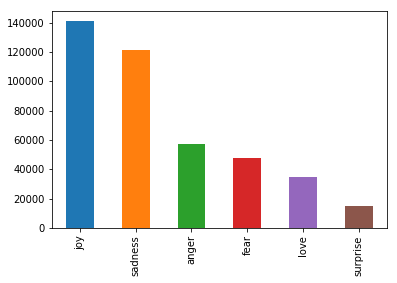

In [6]:
# load data
data = ph.load_from_pickle(directory="data/merged_training.pkl")
data.emotions.value_counts().plot.bar()

In [7]:
data.head(10)

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
18231,i find myself frustrated with christians becau...,love
10714,i am one of those people who feels like going ...,joy
35177,i feel especially pleased about this as this h...,joy
122177,i was struggling with these awful feelings and...,joy
26723,i feel so enraged but helpless at the same time,anger


### 3.1 Preprocessing Data
In the next steps we are going to create tokenize the text, create index mapping for words, and also construct a vocabulary. 

#### Tokenization and Sampling

In [8]:
# retain only text that contain less that 70 tokens to avoid too much padding
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

# sampling
data = data.sample(n=50000);

#### Constructing Vocabulary and Index-Word Mapping

In [9]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [10]:
# construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

# examples of what is in the vocab
inputs.vocab[0:10]

['a',
 'aa',
 'aaa',
 'aaah',
 'aabsolutely',
 'aac',
 'aahed',
 'aaliyah',
 'aaradhya',
 'aaron']

### 3.2 Converting Data into Tensors 
For convenience we would like to convert the data into tensors. 

In [11]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [12]:
# examples of what is in the input tensors
input_tensor[0:2]

[[11609, 752, 8756, 1, 2350, 12147, 11882, 25071, 24557, 4212, 24322],
 [11609, 8747, 22258, 7581, 852, 22421, 26627, 11609, 26485, 12612]]

### 3.3 Padding data
In order to train our recurrent neural network later on in the notebook, it is required padding to generate inputs of same length.

In [13]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [14]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

69


In [15]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [16]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [17]:
input_tensor[0:2]

[array([11609,   752,  8756,     1,  2350, 12147, 11882, 25071, 24557,
         4212, 24322,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]),
 array([11609,  8747, 22258,  7581,   852, 22421, 26627, 11609, 26485,
        12612,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

### 3.4 Binarization
We would like to binarize our target so that we can obtain one-hot encodings as target values. These are easier and more efficient to work with and will be useful when training the models.

In [18]:
### convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [19]:
target_tensor[0:2] 

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0]])

In [20]:
data[0:2]

,text,emotions,token_size
4298,i am feeling a bit inhibited in trying to clar...,sadness,11
61926,i feel so elegant and sophisticated when i wea...,joy,10


In [21]:
get_emotion = lambda t: np.argmax(t)

In [22]:
get_emotion(target_tensor[0])

4

In [23]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [24]:
emotion_dict[get_emotion(target_tensor[0])]

'sadness'

### 3.5 Split data
We would like to split our data into a train and validation set. In addition, we also want a holdout dataset (test set) for evaluating the models.

In [25]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(40000, 40000, 5000, 5000, 5000, 5000)

### 3.6 Data Loader
We can also laod the data into a data loader, which makes it easy to **manipulate the data**, **create batches**, and apply further **transformations**. In PyTorch we can use the `DataLoader` function.

In [26]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 32 # great results at 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 100 # great results at 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

In [27]:
from torch.utils.data import Dataset, DataLoader

In [28]:
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [29]:
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)

train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [30]:
val_dataset.batch_size

32

## 4. Model
After the data has been preprocessed, transformed and prepared it is now time to construct the model or the so-called computation graph that will be used to train our classification models. We are going to use a gated recurrent neural network (GRU), which is considered a more efficient version of a basic RNN. The figure below shows a high-level overview of the model details. 

![alt txt](img/gru-model.png)

### 4.1 Constructing the Model
Below we construct our model:

In [31]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden  

### 4.2 Pretesting model
Since eager execution is enabled we can print the output of the model by passing a sample of the dataset and making sure that the dimensions of the outputs are the expected ones.

In [32]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

In [33]:
# uncomment for cuda access
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# obtain one sample from the data iterator
it = iter(train_dataset)
x, y, x_len = next(it)

# sort the batch first to be able to use with pac_pack sequence
xs, ys, lens = sort_batch(x, y, x_len)

print("Input size: ", xs.size())

output, _ = model(xs.to(device), lens, device)
print(output.size())

Input size:  torch.Size([69, 32])
torch.Size([32, 6])


## 5. Training the Model
Now that we have tested the model, it is time to train it. We will define out optimization algorithm, learnin rate, and other necessary information to train the model.

In [34]:
### Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
# device = torch.device("cuda" if use_cuda else "cpu") # uncomment for cuda
device = torch.device("cpu")

model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

### loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [35]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        predictions, _ = model(inp.permute(1 ,0).to(device), lens, device) # TODO:don't need _   
              
        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))
            
    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):        
        predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.2976
Epoch 1 Batch 100 Val. Loss 0.2643
Epoch 1 Batch 200 Val. Loss 0.2559
Epoch 1 Batch 300 Val. Loss 0.2767
Epoch 1 Batch 400 Val. Loss 0.2916
Epoch 1 Batch 500 Val. Loss 0.2604
Epoch 1 Batch 600 Val. Loss 0.2390
Epoch 1 Batch 700 Val. Loss 0.1975
Epoch 1 Batch 800 Val. Loss 0.2128
Epoch 1 Batch 900 Val. Loss 0.1037
Epoch 1 Batch 1000 Val. Loss 0.0787
Epoch 1 Batch 1100 Val. Loss 0.1102
Epoch 1 Batch 1200 Val. Loss 0.0677
Epoch 1 Loss 0.1826 -- Train Acc. 58.0000 -- Val Acc. 87.0000
Time taken for 1 epoch 143.81666803359985 sec

Epoch 2 Batch 0 Val. Loss 0.0241
Epoch 2 Batch 100 Val. Loss 0.0771
Epoch 2 Batch 200 Val. Loss 0.0239
Epoch 2 Batch 300 Val. Loss 0.0405
Epoch 2 Batch 400 Val. Loss 0.0318
Epoch 2 Batch 500 Val. Loss 0.0268
Epoch 2 Batch 600 Val. Loss 0.0254
Epoch 2 Batch 700 Val. Loss 0.0497
Epoch 2 Batch 800 Val. Loss 0.0622
Epoch 2 Batch 900 Val. Loss 0.0138
Epoch 2 Batch 1000 Val. Loss 0.0345
Epoch 2 Batch 1100 Val. Loss 0.0525
Epoch 2 Batch 1

In [36]:
model.parameters

<bound method Module.parameters of EmoGRU(
  (embedding): Embedding(27348, 256)
  (dropout): Dropout(p=0.5)
  (gru): GRU(256, 100)
  (fc): Linear(in_features=100, out_features=6, bias=True)
)>

## 6. Evaluation on the Testing Data
Now we will evaluate the model with the holdout dataset.

In [37]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

device = "cpu" # we don't need GPU to do testing
model.to("cpu")

for (batch, (inp, targ, lens)) in enumerate(test_dataset):          
    predictions,_ = model(inp.permute(1, 0), lens, device)        
    batch_accuracy = accuracy(targ, predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.detach().numpy() / TEST_N_BATCH)

Test Accuracy:  92.08974358974359


### 6.1 Confusion Matrix
The test accuracy alone is not an interesting performance metric in this case. Let's plot a confusion matrix to get a drilled down view of how the model is performing with regards to each emotion.

Default Classification report
              precision    recall  f1-score   support

       anger       0.94      0.93      0.93       668
        fear       0.90      0.85      0.88       572
         joy       0.94      0.95      0.94      1681
        love       0.89      0.80      0.84       433
     sadness       0.96      0.97      0.97      1462
    surprise       0.72      0.83      0.77       176

   micro avg       0.93      0.93      0.93      4992
   macro avg       0.89      0.89      0.89      4992
weighted avg       0.93      0.93      0.93      4992


Accuracy:
0.9268830128205128
Correct Predictions:  4627
precision: 0.89
recall: 0.89
f1: 0.89

confusion matrix
 [[ 620   15    9    0   24    0]
 [  24  489    1    0   17   41]
 [   5    6 1603   44   12   11]
 [   0    2   80  345    4    2]
 [  13   13   10    0 1424    2]
 [   0   18   11    0    1  146]]
(row=expected, col=predicted)


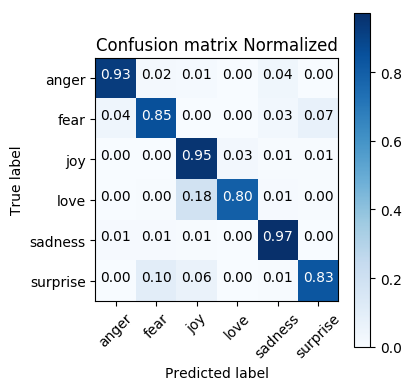

In [38]:
import helpers.evaluate as ev
evaluator = ev.Evaluate()
import pandas as pd

final_predictions = []

for p in all_predictions:
    for sub_p in p:
        final_predictions.append(sub_p.detach().numpy())
        
predictions = [np.argmax(p).item() for p in final_predictions]
targets = [np.argmax(t).item() for t in y_raw]
correct_predictions = float(np.sum(predictions == targets))

# predictions
predictions_human_readable = ((x_raw, predictions))
# actual targets
target_human_readable = ((x_raw,  targets))

emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

# convert results into dataframe
model_test_result = pd.DataFrame(predictions_human_readable[1],columns=["emotion"])
test = pd.DataFrame(target_human_readable[1], columns=["emotion"])

model_test_result.emotion = model_test_result.emotion.map(lambda x: emotion_dict[int(float(x))])
test.emotion = test.emotion.map(lambda x: emotion_dict[int(x)])

evaluator.evaluate_class(model_test_result.emotion, test.emotion );

## Final Words
You have learned how to perform neural-based emotion recognition using RNNs. There are many things you can do after you have completed this tutorial. You can attempt the exercises outlined in the "Outline" section of this notebook. You can also try other types of neural architectures such as LSTMs, Bi-LSTMS, attentions models, and CNNs. In addition, you can also store the models and conduct transfer learning to other emotion-related tasks. 

---

## References
- [Deep Learning for NLP](https://docs.google.com/presentation/d/1cf2H1qMvP1rdKUF5000ifOIRv1_b0bvj0ZTVL7-RaVE/edit?usp=sharing)
- [PyTorch Autograd Tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)
- [A Simple Neural Network from Scratch with PyTorch and Google Colab](https://medium.com/dair-ai/a-simple-neural-network-from-scratch-with-pytorch-and-google-colab-c7f3830618e0)
- [Building RNNs is Fun with PyTorch and Google Colab](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79?source=collection_home---4------2---------------------)
- [Deep Learning for NLP: An Overview of Recent Trends](https://medium.com/dair-ai/deep-learning-for-nlp-an-overview-of-recent-trends-d0d8f40a776d)